In [1]:
from MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx
from SimPEG import (Mesh, Maps, SolverLU, DataMisfit, Regularization,
                    Optimization, InvProblem, Inversion, Directives, Utils)
from scipy.constants import mu_0
import matplotlib
matplotlib.rcParams["font.size"] = 11
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
rxloc = np.r_[0.]
srcloc = np.r_[0.]

frequency = np.logspace(-3, 2, 25)
rxType = "AppredPha"
if rxType == "Zxy":
    rx = ZxyRx(rxloc, component="both", frequency=frequency)
    rxList = [rx]
elif rxType == "AppredPha":
    rx = AppResPhaRx(rxloc, component="both", frequency=frequency)
    rxList = [rx]
src = MT1DSrc(rxList, loc=srcloc)
survey = MT1DSurvey([src])
mesh = survey.setMesh(
        sigma=0.01, max_depth_core=15000., ncell_per_skind=10, n_skind=2,
        core_meshType = "log", max_hz_core=1000.
                     )
sigma = np.ones(mesh.nC) * 0.01
prob = MT1DProblem(mesh, sigmaMap=Maps.ExpMap(mesh), verbose=False)
prob.pair(survey)

>> Smallest cell size = 50 m
>> Padding distance = 316227 m
>> # of padding cells 17
>> # of core cells cells 47


In [3]:
rho_half = 100.
rho_target = 10.

d0, d1, d2, d3, d4 = 0., 600., 1991., 5786., 9786.
rho0, rho1, rho2, rho3, rho4 = 250., 25, 100., 10., 25
d = [d1, d2, d3, d4]
rho = [rho1, rho2, rho3, rho4]

layer_inds0 = np.logical_and(mesh.vectorCCx<-d0, mesh.vectorCCx>-d1)
layer_inds1 = np.logical_and(mesh.vectorCCx<-d1, mesh.vectorCCx>-d2)
layer_inds2 = np.logical_and(mesh.vectorCCx<-d2, mesh.vectorCCx>-d3)
layer_inds3 = np.logical_and(mesh.vectorCCx<-d3, mesh.vectorCCx>-d4)
layer_inds4 = mesh.vectorCCx<-d4

sigma = np.ones(mesh.nC) * np.nan
sigma[layer_inds0] = 1./rho0
sigma[layer_inds1] = 1./rho1
sigma[layer_inds2] = 1./rho2
sigma[layer_inds3] = 1./rho3
sigma[layer_inds4] = 1./rho4

mtrue = np.log(sigma)
dtrue = survey.dpred(mtrue)
np.random.seed(1)
std_appres = 0.05
floor_phase = 2.
uncert = (np.c_[abs(dtrue.reshape((survey.nFreq, 2)))[:,0]*std_appres, np.ones(survey.nFreq)*floor_phase]).flatten()
noise = uncert * np.random.randn(survey.nFreq*2)
survey.dobs = dtrue + noise

(0.002, 0.2)

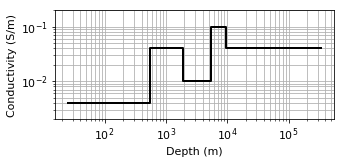

In [4]:
import matplotlib
matplotlib.rcParams["font.size"] = 11
figsize(5, 2)
# sigopt = np.repeat(np.exp(mopt), 2, axis=0)
sigtrue = np.repeat(sigma, 2, axis=0)
z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
# plt.plot(sigopt, z, 'b', lw=2)
plt.plot(-z, sigtrue, 'k', lw=2)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Conductivity (S/m)")
plt.xlabel("Depth (m)")
plt.grid(True, which='both')
plt.ylim(2e-3, 2e-1)
# plt.xlim(1e-4, 1.)

In [5]:
app_res = dtrue.reshape((survey.nFreq, 2))[:,0]
phase = dtrue.reshape((survey.nFreq, 2))[:,1]

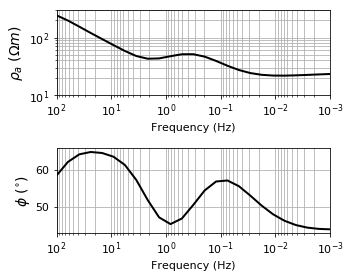

In [6]:
fig = plt.figure(figsize = (5, 4))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.loglog(frequency, app_res, 'k-', lw=2)
ax1.grid(True, which='both')
ax1.set_xlim(frequency.max(), frequency.min())
ax1.set_ylim(10, 3e2)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

ax2.semilogx(frequency, phase, 'k-', lw=2)
ax2.grid(True, which='both')
ax2.set_xlim(frequency.max(), frequency.min())
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("$\phi \ (^{\circ})$", fontsize = 14)
plt.tight_layout()

In [7]:
def run_MT1Dinv(prob, survey, m0,
                std_appres=0.05, floor_phase =2.,
                maxIter = 40,
                alpha_s=1., alpha_x=1., coolingFactor=2., coolingRate=1, 
                beta0=1e1, beta0_ratio=None,
                use_betaest=False, use_target=True):
    np.random.seed(1)
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    dmisfit.W = 1./uncert
    reg = Regularization.Simple(prob.mesh, alpha_s=alpha_s, alpha_x=alpha_x)
    opt = Optimization.InexactGaussNewton(maxIter=maxIter, LSshorten=0.5)
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    # Create an inversion object
    beta = Directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    
    invProb.beta = beta0
    target = Directives.TargetMisfit()
    save = Directives.SaveOutputEveryIteration()
    directs = [beta, save]

    if use_target:
        directs.append(target)
    if use_betaest:
        if beta0_ratio is None:
            beta0_ratio = 1.
        betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
        directs.append(betaest)      
        

    inv = Inversion.BaseInversion(invProb, directiveList=directs)
    prob.counter = opt.counter = Utils.Counter()
    opt.remember('xc')
    mopt = inv.run(m0)
    xc = opt.recall("xc")
    return xc, save

In [8]:
m0 = np.log(0.02) * np.ones(mesh.nC)
xc, save = run_MT1Dinv(prob, survey, m0, 
                       maxIter=40,
                       alpha_s=1., alpha_x=0., beta0 = 9e3,
                       use_betaest=False,
                       use_target=False)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-06-13-11-37.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.00e+03  3.37e+03  0.00e+00  3.37e+03    1.55e+03      0              
   1  6.00e+03  3.12e+03  1.34e-02  3.20e+03    4.50e+02      0              
   2  4.00e+03  3.02e+03  2.71e-02  3.13e+03    4.49e+02      0   Skip BFGS  
   3  2.67e+03  2.88e+03  5.56e-02  3.03e+03    4.22e+02      0   Skip BFGS  
   4  1.78e+03  2.70e+03  1.10e-01  2

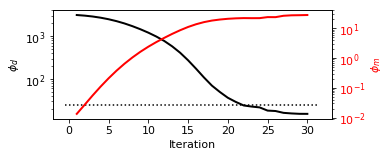

In [9]:
save.load_results()
save.plot_misfit_curves(plot_small_smooth=False)

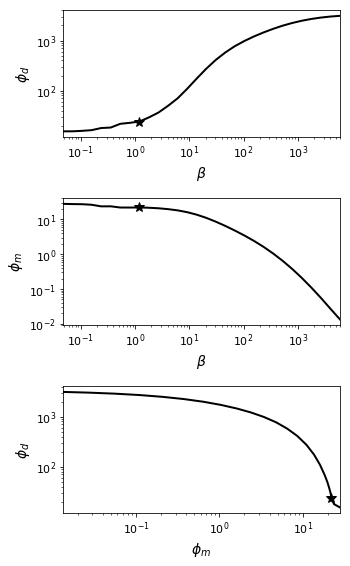

In [10]:
save.plot_tikhonov_curves()

In [11]:
app_res = survey.dobs.reshape((survey.nFreq, 2))[:,0]
phase = survey.dobs.reshape((survey.nFreq, 2))[:,1]

In [12]:
from ipywidgets import interact, IntSlider, ToggleButtons

In [13]:
def view_1Dinversion_results(iteration, scale, save):
    fig = plt.figure(figsize = (10, 5))
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)

    ax1.loglog(save.phi_m, save.phi_d, 'k-', lw=2)
    if save.i_target is not None:
        ax1.loglog(save.phi_m[save.i_target], save.phi_d[save.i_target], 'k*', ms=10)
    ax1.loglog(save.phi_m[iteration], save.phi_d[iteration], 'ro', ms=10)
    ax1.set_xlim(save.phi_m.min(), save.phi_m.max())
    ax1.set_xlabel("$\phi_m$", fontsize = 14)
    ax1.set_ylabel("$\phi_d$", fontsize = 14)
    ax1.set_xscale(scale)
    temp = xc[iteration]
    sigtrue = np.repeat(sigma, 2, axis=0)
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    ax3.plot(-z, sigtrue, 'k', lw=2)
    ax3.plot(-mesh.vectorCCx, np.exp(temp), 'k--', lw=2)
    ax3.set_xscale("log")
    ax3.set_yscale("log")
    ax3.set_ylabel("Conductivity (S/m)")
    ax3.set_xlabel("Depth (m)")
    ax3.grid(True, which='both')
    ax3.set_ylim(2e-3, 2e-1)
    ax3.set_xlim((-z).min(), (-z).max())

    dpred = survey.dpred(xc[iteration])
    app_res_pred = dpred.reshape((survey.nFreq, 2))[:,0]
    phase_pred = dpred.reshape((survey.nFreq, 2))[:,1]
    ax2.loglog(frequency, app_res, 'k-', lw=2)
    ax2.loglog(frequency, app_res_pred, 'kx', markeredgewidth=1)
    ax2.grid(True, which='both')
    ax2.set_xlim(frequency.max(), frequency.min())
    ax2.set_ylim(10, 3e2)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

    ax4.semilogx(frequency, phase, 'k-', lw=2)
    ax4.semilogx(frequency, phase_pred, 'kx', markeredgewidth=1)

    ax4.grid(True, which='both')
    ax4.set_xlim(frequency.max(), frequency.min())
    ax4.set_xlabel("Frequency (Hz)")
    ax4.set_ylabel("Phase (degree)")
    plt.tight_layout()
    plt.show()

def foo(iteration, scale):
    return view_1Dinversion_results(iteration, scale, save)
interact(foo, 
         iteration=IntSlider(min=0, max=save.phi_d.shape[0]-1, step=1, value=0),
         scale=ToggleButtons(options=["linear", "log"], value="log"))

<function __main__.foo>

In [14]:
def MT1D_inv_results(xc, iteration):
    fig = plt.figure(figsize = (5, 7))
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    ax3 = plt.subplot(313)

    temp = xc[iteration]
    sigtrue = np.repeat(sigma, 2, axis=0)
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    ax1.plot(-z, sigtrue, 'k', lw=2)
    ax1.plot(-mesh.vectorCCx, np.exp(temp), 'k--', lw=2)
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_ylabel("Conductivity (S/m)")
    ax1.set_xlabel("Depth (m)")
    ax1.grid(True, which='both')
    ax1.set_ylim(2e-3, 2e-1)
    ax1.set_xlim((-z).min(), 1e5)

    dpred = survey.dpred(xc[iteration])
    app_res_pred = dpred.reshape((survey.nFreq, 2))[:,0]
    phase_pred = dpred.reshape((survey.nFreq, 2))[:,1]
    ax2.loglog(frequency, app_res, 'k-', lw=2)
    ax2.loglog(frequency, app_res_pred, 'kx', markeredgewidth=1)
    ax2.grid(True, which='both')
    ax2.set_xlim(frequency.max(), frequency.min())
    ax2.set_ylim(10, 3e2)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

    ax3.semilogx(frequency, phase, 'k-', lw=2)
    ax3.semilogx(frequency, phase_pred, 'kx', markeredgewidth=1)

    ax3.grid(True, which='both')
    ax3.set_xlim(frequency.max(), frequency.min())
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("$\phi \ (^{\circ})$", fontsize = 14)
    plt.tight_layout()

In [15]:
m0 = np.log(0.02) * np.ones(mesh.nC)
xc_small, save_small = run_MT1Dinv(prob, survey, m0,
                                   coolingFactor=2., coolingRate=3,
                                   alpha_s=1., alpha_x=0., beta0_ratio=1e-1,
                                   use_target=True, use_betaest=True)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-06-13-11-38.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.86e+01  3.37e+03  0.00e+00  3.37e+03    1.55e+03      0              
   1  1.90e+01  6.54e+02  6.06e+00  7.70e+02    1.82e+02      0              
   2  1.27e+01  1.91e+02  1.38e+01  3.66e+02    7.04e+01      0   Skip BFGS  
   3  8.46e+00  1.12e+02  1.64e+01  2.51e+02    3.43e+01      0              
   4  5.64e+00  6.93e+01  1.82e+01  1

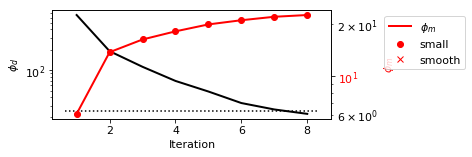

22.1632383809
1.77119555579


In [16]:
save_small.load_results()
save_small.plot_misfit_curves(plot_small_smooth=True)
print save_small.reg.objfcts[0](xc_small[-1])
print save_small.reg.objfcts[1](xc_small[-1])


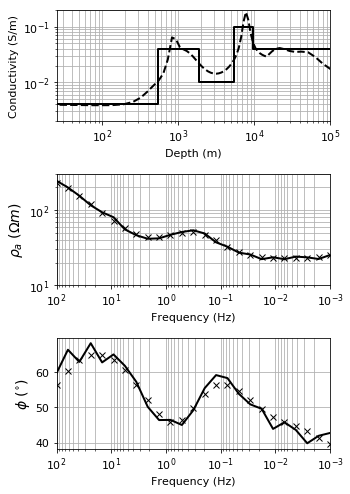

In [17]:
MT1D_inv_results(xc_small, -1)

In [18]:
m0 = np.log(0.02) * np.ones(mesh.nC)
xc_smooth, save_smooth = run_MT1Dinv(prob, survey, m0,
                                   coolingFactor=2., coolingRate=3,
                                   alpha_s=1e-8, alpha_x=1., beta0_ratio=1e-1,
                                   use_target=True, use_betaest=True)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-06-13-11-38.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.45e+01  3.37e+03  0.00e+00  3.37e+03    1.55e+03      0              
   1  2.97e+01  7.00e+02  2.58e-02  7.01e+02    2.20e+02      0              
   2  1.98e+01  2.06e+02  3.66e-01  2.13e+02    1.08e+02      0   Skip BFGS  
   3  1.32e+01  7.99e+01  4.53e-01  8.59e+01    5.94e+01      0              
   4  8.79e+00  3.67e+01  7.21e-01  4

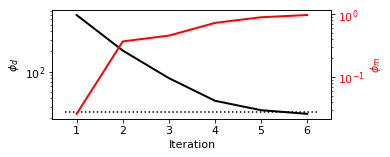

30.0847916181
0.886167155105


In [19]:
save_smooth.load_results()
save_smooth.plot_misfit_curves(plot_small_smooth=False)
print save_smooth.reg.objfcts[0](xc_smooth[-1])
print save_smooth.reg.objfcts[1](xc_smooth[-1])

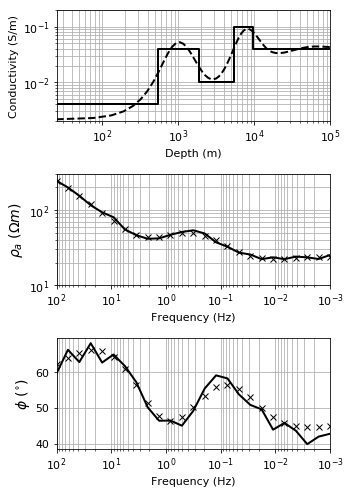

In [20]:
MT1D_inv_results(xc_smooth, -1)